In [1]:
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [2]:
ls


drive/  sample_data/


In [3]:

!pip install torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install Pillow==4.1.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 76.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 10.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for Pillow: filename=Pillow-4.1.1-cp38-cp38-linux_x86_64.whl size=1074892 sha256=639381055612b2e0469dd9876a5c617643150042f6a7dd2dcedce280df3335fb
  Stored in directory: /root/.cache/pip/wheels/5f/7d/2d/ac6d1b3ee8ffb0bfc9bebb84a2a863e7b584de9046e24f67d8
  Created wheel for olefile: filename=olefile-0.46-py2.py3-none-any.whl size=35430 sha256=59e94681c402c62fa160d5438bcdbc1f4cc81e6836675ef7797fcbd2d6ad33ce
  Stored in directory: /root/.cache/pip/wheels/0b/d8/16/1e2d32ad7455728b8af9efdb9d2a0c3d03cd8f2e4be0191b8c
Successfully built Pillow olefile
  Attempting uninstall: Pillow
    Found existing installation: Pillow 7.1.2
    Uninstallin

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torchvision import transforms, models

ImportError: ignored

In [ ]:
vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
    param.requires_grad_(False)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Cuda Available: ', torch.cuda.is_available())
vgg.to(device)

In [6]:

def load_image(path, max_size=400, shape=None):
    image = Image.open(path).convert('RGB')
    
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    if shape is not None:
        size = shape
    
    in_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

In [7]:
content = load_image('drive/My Drive/Colab Notebooks/Deep Learning/PyTorch Scholarship/Style Transfer/assets/surya2.jpg').to(device)

 
style = load_image('drive/My Drive/Colab Notebooks/Deep Learning/PyTorch Scholarship/Style Transfer/assets/oily_mcoilface.jpg', shape=content.shape[-2:]).to(device)
     

FileNotFoundError: ignored

In [8]:
def imconvert(tensor):
    tensor = tensor.cpu().clone().detach()
    tensor = tensor.numpy().squeeze()
    tensor = tensor.transpose(1,2,0)
    tensor = tensor * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    tensor = tensor.clip(0,1)
    return tensor

NameError: ignored

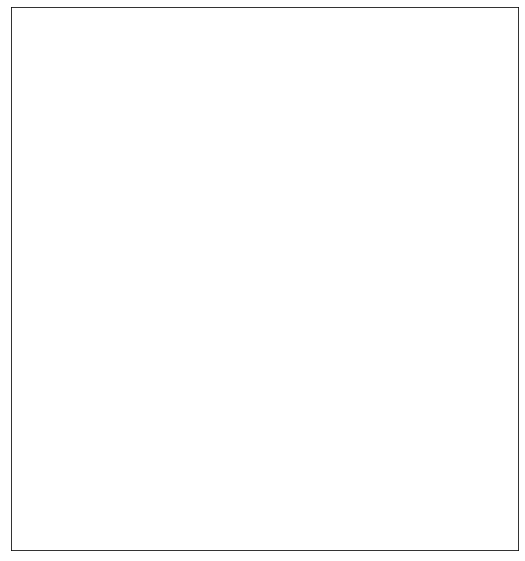

In [9]:

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,2,1, xticks=[], yticks=[])
ax1.imshow(imconvert(content))
ax2 = fig.add_subplot(1,2,2, xticks=[], yticks=[])
ax2.imshow(imconvert(style))

In [10]:
vgg

NameError: ignored

In [11]:
def get_features(image, model, layers=None):
    if layers is None:
        layers = {'0':'conv1_1','5':'conv2_1', '10':'conv3_1', '19':'conv4_1', '28':'conv5_1', '21':'conv4_2'}
    
    features = {}
    for name, layer in model._modules.items():
        image = layer(image)
        if name in layers:
            features[layers[name]]=image
    
    return features

In [12]:
def gram_matrix(tensor):
    batch_size, depth, height, width = tensor.shape
    
    tensor = tensor.view(depth, -1)
    tensor = torch.mm(tensor, tensor.t())
    return tensor
     

In [13]:

style_features = get_features(style, vgg)
content_features = get_features(content, vgg)

style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

#we could start with random image, but it would be good to start with content image
target = content.clone().requires_grad_(True).to(device)

NameError: ignored

In [14]:
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.8,
                 'conv3_1': 0.5,
                 'conv4_1': 0.3,
                 'conv5_1': 0.1}


content_weight = 1  # alpha
style_weight = 5e6  # beta
     

In [15]:

optimizer = torch.optim.Adam([target], lr=0.003)

steps = 2400
print_every = 400

for i in range(1,steps+1):
    
    target_features = get_features(target, vgg)
    content_loss = torch.mean((content_features['conv4_2']-target_features['conv4_2'])**2)
    
    style_loss = 0
    for layer in style_weights:
        
        target_feature = target_features[layer]
        
        _, d, h, w = target_feature.shape
        
        target_gram = gram_matrix(target_feature)
        
        style_gram = style_grams[layer]
        
        layer_style_loss = style_weights[layer]*torch.mean((target_gram - style_gram)**2)
        
        style_loss += layer_style_loss/ (d*h*w)
    
    total_loss = style_weight*style_loss + content_weight*content_loss
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if i%print_every==0:
        print('Total Loss: ', total_loss.item())
        plt.imshow(imconvert(target))


NameError: ignored

NameError: ignored

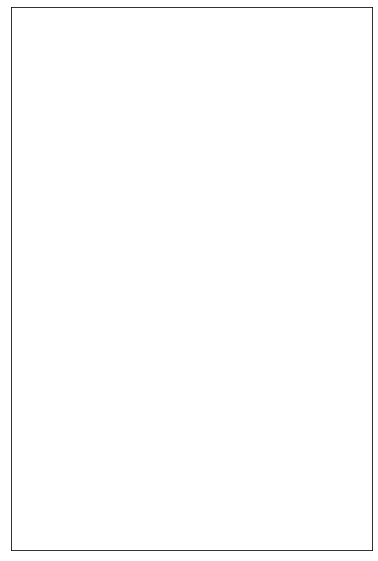

In [16]:

fig = plt.figure(figsize=(22,10))
ax1 = fig.add_subplot(1,3,1, xticks=[], yticks=[])
ax1.imshow(imconvert(content))
ax2 = fig.add_subplot(1,3,2, xticks=[], yticks=[])
ax2.imshow(imconvert(style))

ax3 = fig.add_subplot(1,3,3, xticks=[], yticks=[])
ax3.imshow(imconvert(target))

In [17]:
plt.imsave('drive/My Drive/Colab Notebooks/Deep Learning/PyTorch Scholarship/Style Transfer/assets/surya2_style.jpg', imconvert(target))
     

NameError: ignored